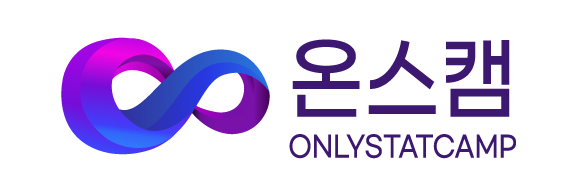

# 기본 분류: 의류 이미지 분류

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, Model

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)


2.15.0


## CIFAR10 데이터셋 임포트하기

CIFAR10 데이터세트에는 10개 클래스에 60,000개의 컬러 이미지가 포함되어 있으며 각 클래스에는 6,000개의 이미지가 있습니다. 이 데이터세트는 50,000개의 훈련 이미지와 10,000개의 테스트 이미지로 나뉩니다. 클래스는 상호 배타적이며 서로 겹치지 않습니다.

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## 데이터 탐색

데이터세트가 올바른지 확인하기 위해 훈련 세트의 처음 25개 이미지를 플로팅하고 각 이미지 아래에 클래스 이름을 표시해 보겠습니다.



In [4]:
train_images.shape

(50000, 32, 32, 3)

In [7]:
len(train_images)

50000

비슷하게 훈련 세트에는 50,000개의 레이블이 있습니다:

In [5]:
len(train_labels)

50000

각 레이블은 0과 9사이의 정수입니다:

In [6]:
train_labels

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

테스트 세트에는 10,000개의 이미지가 있습니다. 이 이미지도 32x32x3 픽셀로 표현됩니다:

In [7]:
test_images.shape

(10000, 32, 32, 3)

In [ ]:
len(test_images)

테스트 세트는 10,000개의 이미지에 대한 레이블을 가지고 있습니다:

In [8]:
len(test_labels)

10000

## 데이터 전처리

네트워크를 훈련하기 전에 데이터를 전처리해야 합니다. 훈련 세트에 있는 첫 번째 이미지를 보면 픽셀 값의 범위가 0~1 사이라는 것을 알 수 있습니다:

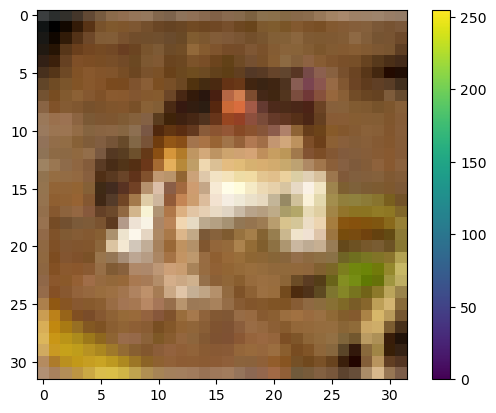

In [9]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

신경망 모델에 주입하기 전에 이 값의 범위를 0~1 사이로 조정하겠습니다. 이렇게 하려면 255로 나누어야 합니다. *훈련 세트*와 *테스트 세트*를 동일한 방식으로 전처리하는 것이 중요합니다:

In [10]:
train_images = train_images.astype(np.float32)
train_images = train_images / 255.0

test_images = test_images.astype(np.float32)
test_images = test_images / 255.0

In [11]:
train_labels = train_labels.astype(np.int32)
test_labels = test_labels.astype(np.int32)

*훈련 세트*에서 처음 25개 이미지와 그 아래 클래스 이름을 출력해 보죠. 데이터 포맷이 올바른지 확인하고 네트워크 구성과 훈련할 준비를 마칩니다.

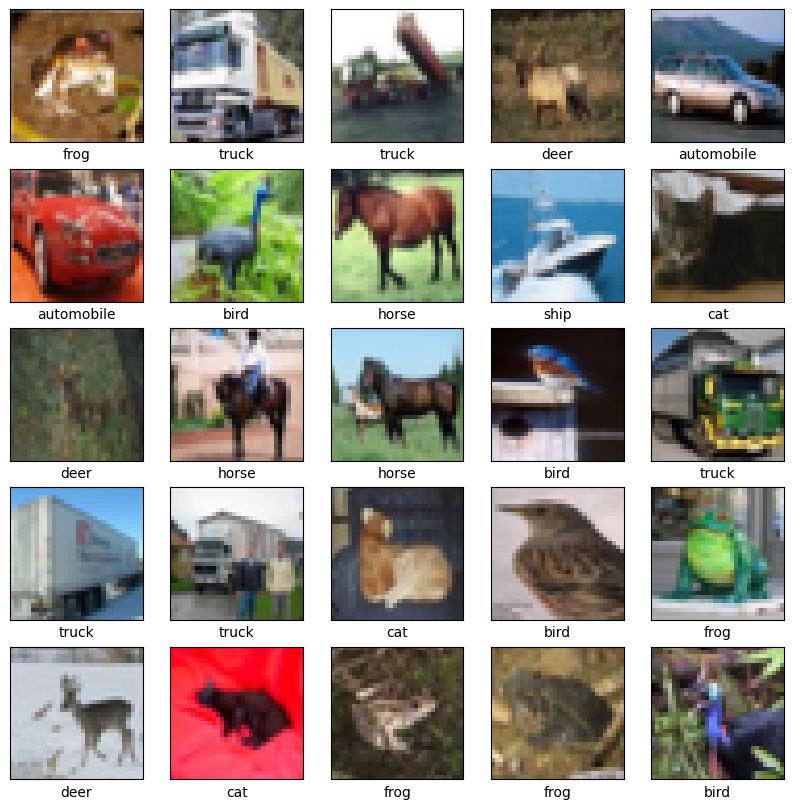

In [12]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## data| augmentation

신경망 모델을 만들려면 모델의 층을 구성한 다음 모델을 컴파일합니다.

In [13]:
IMG_SIZE = 32 * 2

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
])

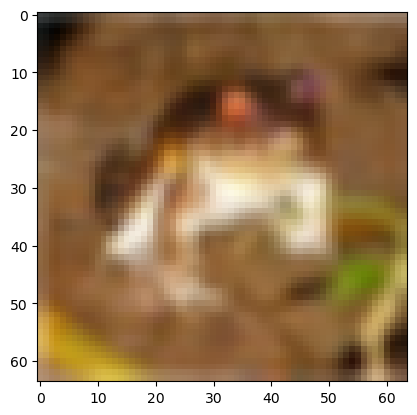

In [14]:
result = resize_and_rescale(train_images[0])
_ = plt.imshow(result)

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
])

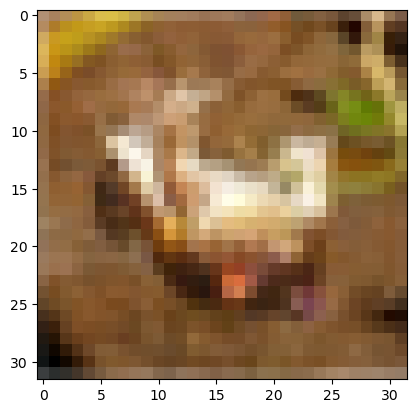

In [16]:
result = data_augmentation(train_images[0])
_ = plt.imshow(result)

In [17]:
def image_preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=(IMG_SIZE, IMG_SIZE))
    label = tf.cast(label, tf.int32)
    return image, label

In [18]:
def image_augmentation(image, label, seed):
    # image = tf.image.resize_with_crop_or_pad(image, target_height=224, target_width=224)
    # image = tf.image.random_crop(image, size=(224, 224, 3))
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    
    # Random crop back to the original size.
    image = tf.image.resize_with_crop_or_pad(image, int(IMG_SIZE*1.1), int(IMG_SIZE*1.1))
    image = tf.image.stateless_random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
    
    # Random brightness.
    image = tf.image.stateless_random_brightness(image, max_delta=0.5, seed=new_seed)
    
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    
    return image, label

In [19]:
# Create a generator.
rng = tf.random.Generator.from_seed(123, alg='philox')

In [20]:
# Create a wrapper function for updating seeds.
def wrapper_augmentation(image, label):
    seed = rng.make_seeds(2)[0]
    image, label = image_augmentation(image, label, seed)
    return image, label

## Datasets

### train datasets

In [21]:
datasets_train = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

In [22]:
datasets_train = datasets_train.shuffle(buffer_size=len(train_labels))
datasets_train = datasets_train.map(image_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
datasets_train = datasets_train.map(wrapper_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
datasets_train = datasets_train.batch(batch_size=32)
datasets_train = datasets_train.prefetch(buffer_size=tf.data.AUTOTUNE)

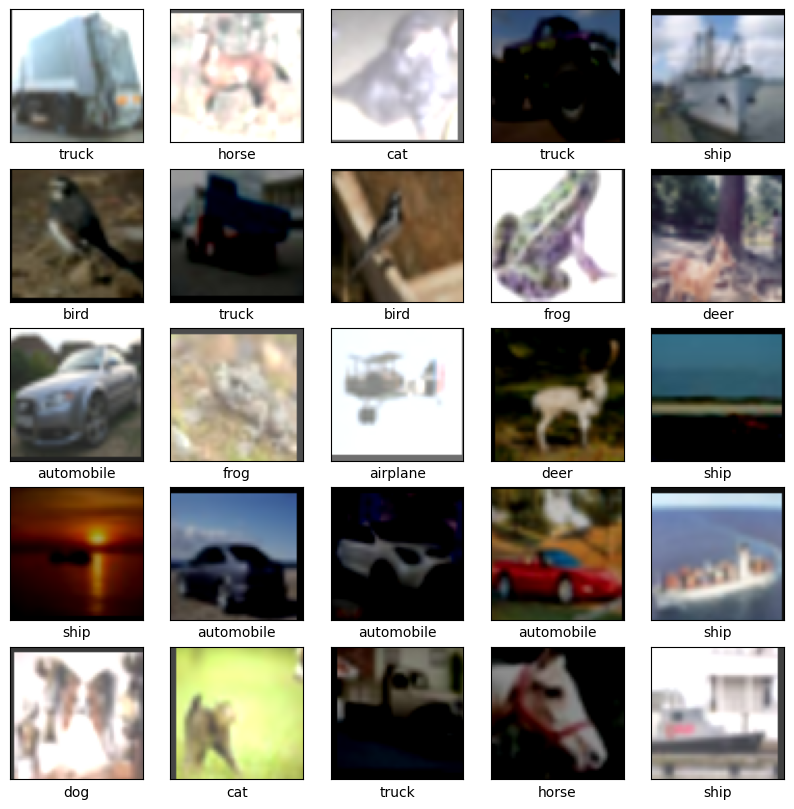

In [23]:
plt.figure(figsize=(10,10))

images, labels = next(iter(datasets_train))

for i, (image, label) in enumerate(zip(images, labels)):
    
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[int(label.numpy())])
    
    if i + 1 >= 25:
        break
    
plt.show()

### test datasets

In [24]:
datasets_test = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [25]:
datasets_test = datasets_test.map(image_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
datasets_test = datasets_test.batch(batch_size=32)
datasets_test = datasets_test.prefetch(buffer_size=tf.data.AUTOTUNE)

## https://keras.io/api/applications/

Keras 애플리케이션은 사전 훈련된 가중치와 함께 사용할 수 있는 딥 러닝 모델입니다. 이러한 모델은 예측, 특징 추출 및 미세 조정에 사용될 수 있습니다.

모델을 인스턴스화할 때 가중치가 자동으로 다운로드됩니다. 에 저장되어 있습니다 ~/.keras/models/.

인스턴스화 시 Keras 구성 파일에 설정된 이미지 데이터 형식에 따라 모델이 구축됩니다 ~/.keras/keras.json. 예를 들어, 을 설정한 경우 image_data_format=channels_last이 저장소에서 로드된 모든 모델은 "높이-너비-깊이" 데이터 형식 규칙에 따라 구축됩니다.

<table>
<thead>
<tr>
<th>Model</th>
<th style="text-align: right;">Size (MB)</th>
<th style="text-align: right;">Top-1 Accuracy</th>
<th style="text-align: right;">Top-5 Accuracy</th>
<th style="text-align: right;">Parameters</th>
<th style="text-align: right;">Depth</th>
<th style="text-align: right;">Time (ms) per inference step (CPU)</th>
<th style="text-align: right;">Time (ms) per inference step (GPU)</th>
</tr>
</thead>
<tbody>
<tr>
<td><a href="xception">Xception</a></td>
<td style="text-align: right;">88</td>
<td style="text-align: right;">79.0%</td>
<td style="text-align: right;">94.5%</td>
<td style="text-align: right;">22.9M</td>
<td style="text-align: right;">81</td>
<td style="text-align: right;">109.4</td>
<td style="text-align: right;">8.1</td>
</tr>
<tr>
<td><a href="vgg/#vgg16-function">VGG16</a></td>
<td style="text-align: right;">528</td>
<td style="text-align: right;">71.3%</td>
<td style="text-align: right;">90.1%</td>
<td style="text-align: right;">138.4M</td>
<td style="text-align: right;">16</td>
<td style="text-align: right;">69.5</td>
<td style="text-align: right;">4.2</td>
</tr>
<tr>
<td><a href="vgg/#vgg19-function">VGG19</a></td>
<td style="text-align: right;">549</td>
<td style="text-align: right;">71.3%</td>
<td style="text-align: right;">90.0%</td>
<td style="text-align: right;">143.7M</td>
<td style="text-align: right;">19</td>
<td style="text-align: right;">84.8</td>
<td style="text-align: right;">4.4</td>
</tr>
<tr>
<td><a href="resnet/#resnet50-function">ResNet50</a></td>
<td style="text-align: right;">98</td>
<td style="text-align: right;">74.9%</td>
<td style="text-align: right;">92.1%</td>
<td style="text-align: right;">25.6M</td>
<td style="text-align: right;">107</td>
<td style="text-align: right;">58.2</td>
<td style="text-align: right;">4.6</td>
</tr>
<tr>
<td><a href="resnet/#resnet50v2-function">ResNet50V2</a></td>
<td style="text-align: right;">98</td>
<td style="text-align: right;">76.0%</td>
<td style="text-align: right;">93.0%</td>
<td style="text-align: right;">25.6M</td>
<td style="text-align: right;">103</td>
<td style="text-align: right;">45.6</td>
<td style="text-align: right;">4.4</td>
</tr>
<tr>
<td><a href="resnet/#resnet101-function">ResNet101</a></td>
<td style="text-align: right;">171</td>
<td style="text-align: right;">76.4%</td>
<td style="text-align: right;">92.8%</td>
<td style="text-align: right;">44.7M</td>
<td style="text-align: right;">209</td>
<td style="text-align: right;">89.6</td>
<td style="text-align: right;">5.2</td>
</tr>
<tr>
<td><a href="resnet/#resnet101v2-function">ResNet101V2</a></td>
<td style="text-align: right;">171</td>
<td style="text-align: right;">77.2%</td>
<td style="text-align: right;">93.8%</td>
<td style="text-align: right;">44.7M</td>
<td style="text-align: right;">205</td>
<td style="text-align: right;">72.7</td>
<td style="text-align: right;">5.4</td>
</tr>
<tr>
<td><a href="resnet/#resnet152-function">ResNet152</a></td>
<td style="text-align: right;">232</td>
<td style="text-align: right;">76.6%</td>
<td style="text-align: right;">93.1%</td>
<td style="text-align: right;">60.4M</td>
<td style="text-align: right;">311</td>
<td style="text-align: right;">127.4</td>
<td style="text-align: right;">6.5</td>
</tr>
<tr>
<td><a href="resnet/#resnet152v2-function">ResNet152V2</a></td>
<td style="text-align: right;">232</td>
<td style="text-align: right;">78.0%</td>
<td style="text-align: right;">94.2%</td>
<td style="text-align: right;">60.4M</td>
<td style="text-align: right;">307</td>
<td style="text-align: right;">107.5</td>
<td style="text-align: right;">6.6</td>
</tr>
<tr>
<td><a href="inceptionv3">InceptionV3</a></td>
<td style="text-align: right;">92</td>
<td style="text-align: right;">77.9%</td>
<td style="text-align: right;">93.7%</td>
<td style="text-align: right;">23.9M</td>
<td style="text-align: right;">189</td>
<td style="text-align: right;">42.2</td>
<td style="text-align: right;">6.9</td>
</tr>
<tr>
<td><a href="inceptionresnetv2">InceptionResNetV2</a></td>
<td style="text-align: right;">215</td>
<td style="text-align: right;">80.3%</td>
<td style="text-align: right;">95.3%</td>
<td style="text-align: right;">55.9M</td>
<td style="text-align: right;">449</td>
<td style="text-align: right;">130.2</td>
<td style="text-align: right;">10.0</td>
</tr>
<tr>
<td><a href="mobilenet">MobileNet</a></td>
<td style="text-align: right;">16</td>
<td style="text-align: right;">70.4%</td>
<td style="text-align: right;">89.5%</td>
<td style="text-align: right;">4.3M</td>
<td style="text-align: right;">55</td>
<td style="text-align: right;">22.6</td>
<td style="text-align: right;">3.4</td>
</tr>
<tr>
<td><a href="mobilenet/#mobilenetv2-function">MobileNetV2</a></td>
<td style="text-align: right;">14</td>
<td style="text-align: right;">71.3%</td>
<td style="text-align: right;">90.1%</td>
<td style="text-align: right;">3.5M</td>
<td style="text-align: right;">105</td>
<td style="text-align: right;">25.9</td>
<td style="text-align: right;">3.8</td>
</tr>
<tr>
<td><a href="densenet/#densenet121-function">DenseNet121</a></td>
<td style="text-align: right;">33</td>
<td style="text-align: right;">75.0%</td>
<td style="text-align: right;">92.3%</td>
<td style="text-align: right;">8.1M</td>
<td style="text-align: right;">242</td>
<td style="text-align: right;">77.1</td>
<td style="text-align: right;">5.4</td>
</tr>
<tr>
<td><a href="densenet/#densenet169-function">DenseNet169</a></td>
<td style="text-align: right;">57</td>
<td style="text-align: right;">76.2%</td>
<td style="text-align: right;">93.2%</td>
<td style="text-align: right;">14.3M</td>
<td style="text-align: right;">338</td>
<td style="text-align: right;">96.4</td>
<td style="text-align: right;">6.3</td>
</tr>
<tr>
<td><a href="densenet/#densenet201-function">DenseNet201</a></td>
<td style="text-align: right;">80</td>
<td style="text-align: right;">77.3%</td>
<td style="text-align: right;">93.6%</td>
<td style="text-align: right;">20.2M</td>
<td style="text-align: right;">402</td>
<td style="text-align: right;">127.2</td>
<td style="text-align: right;">6.7</td>
</tr>
<tr>
<td><a href="nasnet/#nasnetmobile-function">NASNetMobile</a></td>
<td style="text-align: right;">23</td>
<td style="text-align: right;">74.4%</td>
<td style="text-align: right;">91.9%</td>
<td style="text-align: right;">5.3M</td>
<td style="text-align: right;">389</td>
<td style="text-align: right;">27.0</td>
<td style="text-align: right;">6.7</td>
</tr>
<tr>
<td><a href="nasnet/#nasnetlarge-function">NASNetLarge</a></td>
<td style="text-align: right;">343</td>
<td style="text-align: right;">82.5%</td>
<td style="text-align: right;">96.0%</td>
<td style="text-align: right;">88.9M</td>
<td style="text-align: right;">533</td>
<td style="text-align: right;">344.5</td>
<td style="text-align: right;">20.0</td>
</tr>
<tr>
<td><a href="efficientnet/#efficientnetb0-function">EfficientNetB0</a></td>
<td style="text-align: right;">29</td>
<td style="text-align: right;">77.1%</td>
<td style="text-align: right;">93.3%</td>
<td style="text-align: right;">5.3M</td>
<td style="text-align: right;">132</td>
<td style="text-align: right;">46.0</td>
<td style="text-align: right;">4.9</td>
</tr>
<tr>
<td><a href="efficientnet/#efficientnetb1-function">EfficientNetB1</a></td>
<td style="text-align: right;">31</td>
<td style="text-align: right;">79.1%</td>
<td style="text-align: right;">94.4%</td>
<td style="text-align: right;">7.9M</td>
<td style="text-align: right;">186</td>
<td style="text-align: right;">60.2</td>
<td style="text-align: right;">5.6</td>
</tr>
<tr>
<td><a href="efficientnet/#efficientnetb2-function">EfficientNetB2</a></td>
<td style="text-align: right;">36</td>
<td style="text-align: right;">80.1%</td>
<td style="text-align: right;">94.9%</td>
<td style="text-align: right;">9.2M</td>
<td style="text-align: right;">186</td>
<td style="text-align: right;">80.8</td>
<td style="text-align: right;">6.5</td>
</tr>
<tr>
<td><a href="efficientnet/#efficientnetb3-function">EfficientNetB3</a></td>
<td style="text-align: right;">48</td>
<td style="text-align: right;">81.6%</td>
<td style="text-align: right;">95.7%</td>
<td style="text-align: right;">12.3M</td>
<td style="text-align: right;">210</td>
<td style="text-align: right;">140.0</td>
<td style="text-align: right;">8.8</td>
</tr>
<tr>
<td><a href="efficientnet/#efficientnetb4-function">EfficientNetB4</a></td>
<td style="text-align: right;">75</td>
<td style="text-align: right;">82.9%</td>
<td style="text-align: right;">96.4%</td>
<td style="text-align: right;">19.5M</td>
<td style="text-align: right;">258</td>
<td style="text-align: right;">308.3</td>
<td style="text-align: right;">15.1</td>
</tr>
<tr>
<td><a href="efficientnet/#efficientnetb5-function">EfficientNetB5</a></td>
<td style="text-align: right;">118</td>
<td style="text-align: right;">83.6%</td>
<td style="text-align: right;">96.7%</td>
<td style="text-align: right;">30.6M</td>
<td style="text-align: right;">312</td>
<td style="text-align: right;">579.2</td>
<td style="text-align: right;">25.3</td>
</tr>
<tr>
<td><a href="efficientnet/#efficientnetb6-function">EfficientNetB6</a></td>
<td style="text-align: right;">166</td>
<td style="text-align: right;">84.0%</td>
<td style="text-align: right;">96.8%</td>
<td style="text-align: right;">43.3M</td>
<td style="text-align: right;">360</td>
<td style="text-align: right;">958.1</td>
<td style="text-align: right;">40.4</td>
</tr>
<tr>
<td><a href="efficientnet/#efficientnetb7-function">EfficientNetB7</a></td>
<td style="text-align: right;">256</td>
<td style="text-align: right;">84.3%</td>
<td style="text-align: right;">97.0%</td>
<td style="text-align: right;">66.7M</td>
<td style="text-align: right;">438</td>
<td style="text-align: right;">1578.9</td>
<td style="text-align: right;">61.6</td>
</tr>
<tr>
<td><a href="efficientnet_v2/#efficientnetv2b0-function">EfficientNetV2B0</a></td>
<td style="text-align: right;">29</td>
<td style="text-align: right;">78.7%</td>
<td style="text-align: right;">94.3%</td>
<td style="text-align: right;">7.2M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="efficientnet_v2/#efficientnetv2b1-function">EfficientNetV2B1</a></td>
<td style="text-align: right;">34</td>
<td style="text-align: right;">79.8%</td>
<td style="text-align: right;">95.0%</td>
<td style="text-align: right;">8.2M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="efficientnet_v2/#efficientnetv2b2-function">EfficientNetV2B2</a></td>
<td style="text-align: right;">42</td>
<td style="text-align: right;">80.5%</td>
<td style="text-align: right;">95.1%</td>
<td style="text-align: right;">10.2M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="efficientnet_v2/#efficientnetv2b3-function">EfficientNetV2B3</a></td>
<td style="text-align: right;">59</td>
<td style="text-align: right;">82.0%</td>
<td style="text-align: right;">95.8%</td>
<td style="text-align: right;">14.5M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="efficientnet_v2/#efficientnetv2s-function">EfficientNetV2S</a></td>
<td style="text-align: right;">88</td>
<td style="text-align: right;">83.9%</td>
<td style="text-align: right;">96.7%</td>
<td style="text-align: right;">21.6M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="efficientnet_v2/#efficientnetv2m-function">EfficientNetV2M</a></td>
<td style="text-align: right;">220</td>
<td style="text-align: right;">85.3%</td>
<td style="text-align: right;">97.4%</td>
<td style="text-align: right;">54.4M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="efficientnet_v2/#efficientnetv2l-function">EfficientNetV2L</a></td>
<td style="text-align: right;">479</td>
<td style="text-align: right;">85.7%</td>
<td style="text-align: right;">97.5%</td>
<td style="text-align: right;">119.0M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="convnext/#convnexttiny-function">ConvNeXtTiny</a></td>
<td style="text-align: right;">109.42</td>
<td style="text-align: right;">81.3%</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">28.6M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="convnext/#convnextsmall-function">ConvNeXtSmall</a></td>
<td style="text-align: right;">192.29</td>
<td style="text-align: right;">82.3%</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">50.2M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="convnext/#convnextbase-function">ConvNeXtBase</a></td>
<td style="text-align: right;">338.58</td>
<td style="text-align: right;">85.3%</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">88.5M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="convnext/#convnextlarge-function">ConvNeXtLarge</a></td>
<td style="text-align: right;">755.07</td>
<td style="text-align: right;">86.3%</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">197.7M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="convnext/#convnextxlarge-function">ConvNeXtXLarge</a></td>
<td style="text-align: right;">1310</td>
<td style="text-align: right;">86.7%</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">350.1M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
</tbody>
</table>

### 층 설정

신경망의 기본 빌딩 블록은 [*레이어*](https://www.tensorflow.org/api_docs/python/tf/keras/layers) 입니다. 레이어는 레이어에 공급된 데이터로부터 표현을 추출합니다. 이러한 표현은 당면한 문제에 의미가 있어야 합니다.

대부분 딥러닝은 간단한 층을 연결하여 구성됩니다. `tf.keras.layers.Dense`와 같은 층들의 가중치(parameter)는 훈련하는 동안 학습됩니다.

In [26]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [27]:
input_shape = (IMG_SIZE, IMG_SIZE, 3)

In [28]:
MobileNetV2 = tf.keras.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights=None
) 

In [29]:
inputs = MobileNetV2.input

In [30]:
x = MobileNetV2.output

In [31]:
x = layers.GlobalAveragePooling2D()(x)

In [32]:
x

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

In [33]:
x = layers.LayerNormalization()(x)

In [34]:
x

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'layer_normalization')>

In [35]:
outputs = layers.Dense(len(class_names), activation='softmax')(x)

In [36]:
outputs

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense')>

In [37]:
model = Model(inputs=inputs, outputs=outputs)

In [38]:
model.summary(show_trainable=True)

Model: "model"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            Y          
                                                                                                             
 Conv1 (Conv2D)              (None, 32, 32, 32)           864       ['input_1[0][0]']             Y          
                                                                                                             
 bn_Conv1 (BatchNormalizati  (None, 32, 32, 32)           128       ['Conv1[0][0]']               Y          
 on)                                                                                                         
                                                                                                         

                                                                                                             
 block_2_add (Add)           (None, 16, 16, 24)           0         ['block_1_project_BN[0][0]'   Y          
                                                                    , 'block_2_project_BN[0][0]              
                                                                    ']                                       
                                                                                                             
 block_3_expand (Conv2D)     (None, 16, 16, 144)          3456      ['block_2_add[0][0]']         Y          
                                                                                                             
 block_3_expand_BN (BatchNo  (None, 16, 16, 144)          576       ['block_3_expand[0][0]']      Y          
 rmalization)                                                                                                
          

                                                                                                             
 block_5_project_BN (BatchN  (None, 8, 8, 32)             128       ['block_5_project[0][0]']     Y          
 ormalization)                                                                                               
                                                                                                             
 block_5_add (Add)           (None, 8, 8, 32)             0         ['block_4_add[0][0]',         Y          
                                                                     'block_5_project_BN[0][0]'              
                                                                    ]                                        
                                                                                                             
 block_6_expand (Conv2D)     (None, 8, 8, 192)            6144      ['block_5_add[0][0]']         Y          
          

                                                                                                             
 block_8_project (Conv2D)    (None, 4, 4, 64)             24576     ['block_8_depthwise_relu[0]   Y          
                                                                    [0]']                                    
                                                                                                             
 block_8_project_BN (BatchN  (None, 4, 4, 64)             256       ['block_8_project[0][0]']     Y          
 ormalization)                                                                                               
                                                                                                             
 block_8_add (Add)           (None, 4, 4, 64)             0         ['block_7_add[0][0]',         Y          
                                                                     'block_8_project_BN[0][0]'              
          

 block_11_depthwise_relu (R  (None, 4, 4, 576)            0         ['block_11_depthwise_BN[0][   Y          
 eLU)                                                               0]']                                     
                                                                                                             
 block_11_project (Conv2D)   (None, 4, 4, 96)             55296     ['block_11_depthwise_relu[0   Y          
                                                                    ][0]']                                   
                                                                                                             
 block_11_project_BN (Batch  (None, 4, 4, 96)             384       ['block_11_project[0][0]']    Y          
 Normalization)                                                                                              
                                                                                                             
 block_11_

                                                                                                             
 block_14_depthwise (Depthw  (None, 2, 2, 960)            8640      ['block_14_expand_relu[0][0   Y          
 iseConv2D)                                                         ]']                                      
                                                                                                             
 block_14_depthwise_BN (Bat  (None, 2, 2, 960)            3840      ['block_14_depthwise[0][0]'   Y          
 chNormalization)                                                   ]                                        
                                                                                                             
 block_14_depthwise_relu (R  (None, 2, 2, 960)            0         ['block_14_depthwise_BN[0][   Y          
 eLU)                                                               0]']                                     
          

 ion)                                                                                                        
                                                                                                             
 out_relu (ReLU)             (None, 2, 2, 1280)           0         ['Conv_1_bn[0][0]']           Y          
                                                                                                             
 global_average_pooling2d (  (None, 1280)                 0         ['out_relu[0][0]']            Y          
 GlobalAveragePooling2D)                                                                                     
                                                                                                             
 layer_normalization (Layer  (None, 1280)                 2560      ['global_average_pooling2d[   Y          
 Normalization)                                                     0][0]']                                  
          


### 모델 컴파일

모델을 훈련할 준비가 되기 전에 몇 가지 설정이 더 필요합니다. 다음은 모델의 [*컴파일*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) 단계에서 추가됩니다.

- [*손실 함수*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) - 훈련 중 모델이 얼마나 정확한지 측정합니다. 모델을 올바른 방향으로 "조정"하려면 이 함수를 최소화해야 합니다.
- [*옵티마이저*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) - 모델이 인식하는 데이터와 해당 손실 함수를 기반으로 모델이 업데이트되는 방식입니다.
- [*메트릭*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) — 훈련 및 테스트 단계를 모니터링하는 데 사용됩니다. 다음 예에서는 올바르게 분류된 이미지의 비율인 *정확도*를 사용합니다.

In [39]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-03),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[
                  tf.keras.metrics.SparseCategoricalAccuracy()
              ])

## 모델 훈련

신경망 모델을 훈련하려면 다음 단계가 필요합니다.

1. 훈련 데이터를 모델에 주입합니다-이 예에서는 `train_images`와 `train_labels` 배열입니다.
2. 모델이 이미지와 레이블을 매핑하는 방법을 배웁니다.
3. 테스트 세트에 대한 모델의 예측을 만듭니다-이 예에서는 `test_images` 배열입니다. 이 예측이 `test_labels` 배열의 레이블과 맞는지 확인합니다.
4. 예측이 `test_labels` 배열의 레이블과 일치하는지 확인합니다.


### 모델 피드

훈련을 시작하려면 [`model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) 메서드를 호출합니다. 모델을 훈련 데이터에 "맞추기(fit)" 때문에 이렇게 불립니다.

In [40]:
history  = model.fit(datasets_train, epochs=3, validation_data=datasets_test)

Epoch 1/3

1563/1563 [==============================] - 201s 120ms/step - loss: 2.1276 - sparse_categorical_accuracy: 0.2420 - val_loss: 2.8971 - val_sparse_categorical_accuracy: 0.1000
Epoch 2/3
1563/1563 [==============================] - 198s 126ms/step - loss: 1.7411 - sparse_categorical_accuracy: 0.3698 - val_loss: 2.6711 - val_sparse_categorical_accuracy: 0.1000
Epoch 3/3
1563/1563 [==============================] - 201s 128ms/step - loss: 1.5190 - sparse_categorical_accuracy: 0.4530 - val_loss: 2.2896 - val_sparse_categorical_accuracy: 0.1333


모델이 훈련되면서 손실과 정확도 지표가 출력됩니다. 이 모델은 훈련 세트에서 약 0.88(88%) 정도의 정확도를 달성합니다.

### 정확도 평가

다음으로, 모델이 테스트 데이터세트에서 작동하는 방식을 비교합니다.

In [41]:
test_loss, test_acc = model.evaluate(datasets_test, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 12s - loss: 2.2896 - sparse_categorical_accuracy: 0.1333 - 12s/epoch - 37ms/step

Test accuracy: 0.13330000638961792


테스트 세트의 정확도가 훈련 세트의 정확도보다 조금 낮습니다. 훈련 세트의 정확도와 테스트 세트의 정확도 사이의 차이는 *과대적합*(overfitting) 때문입니다. 과대적합은 머신러닝 모델이 훈련 데이터보다 새로운 데이터에서 성능이 낮아지는 현상을 말합니다.

- 과대적합 시연
- 과대적합을 방지하기 위한 전략

### 예측하기

훈련된 모델을 사용하여 일부 이미지에 대한 예측을 수행할 수 있습니다. 

In [42]:
predictions = model.predict(datasets_test)

313/313 [==============================] - 13s 38ms/step


In [43]:
predictions

array([[0.09084122, 0.07138637, 0.05228249, ..., 0.10897905, 0.25020608,
        0.12910569],
       [0.11690895, 0.09406079, 0.02280054, ..., 0.05430789, 0.49676692,
        0.11980171],
       [0.11192985, 0.10597943, 0.03112078, ..., 0.08218028, 0.38455433,
        0.1449325 ],
       ...,
       [0.10085665, 0.04028878, 0.0714401 , ..., 0.13400596, 0.20427065,
        0.09242414],
       [0.08263514, 0.06523753, 0.07100179, ..., 0.1753385 , 0.15449008,
        0.09140576],
       [0.08057832, 0.06492502, 0.06218814, ..., 0.16538474, 0.16915026,
        0.10009911]], dtype=float32)

여기서는 테스트 세트에 있는 각 이미지의 레이블을 예측했습니다. 첫 번째 예측을 확인해 보죠:

In [44]:
predictions[0]

array([0.09084122, 0.07138637, 0.05228249, 0.11151665, 0.08111986,
       0.08603621, 0.01852643, 0.10897905, 0.25020608, 0.12910569],
      dtype=float32)

이 예측은 10개의 숫자 배열로 나타납니다. 이 값은 10개의 옷 품목에 상응하는 모델의 신뢰도(confidence)를 나타냅니다. 가장 높은 신뢰도를 가진 레이블을 찾아보죠:

In [45]:
np.argmax(predictions[0])

8

모델은 이 이미지가 앵클 부츠(`class_name[9]`)라고 가장 확신하고 있습니다. 이 값이 맞는지 테스트 레이블을 확인해 보죠:

In [46]:
test_labels[0]

array([3])

10개 클래스에 대한 예측을 모두 그래프로 표현해 보겠습니다:

In [47]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i][0], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
               color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i][0]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

### 예측 확인

훈련된 모델을 사용하여 일부 이미지에 대한 예측을 수행할 수 있습니다.

0번째 원소의 이미지, 예측, 신뢰도 점수 배열을 확인해 보겠습니다.

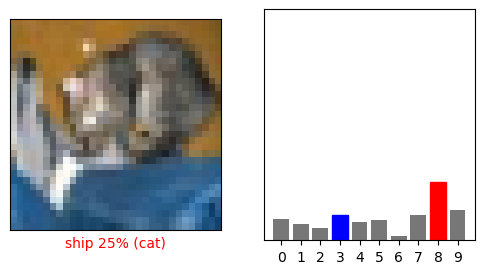

In [48]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

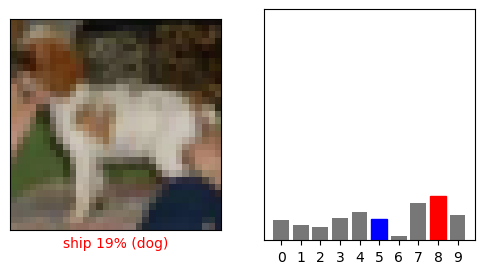

In [49]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

몇 개의 이미지의 예측을 출력해 보죠. 올바르게 예측된 레이블은 파란색이고 잘못 예측된 레이블은 빨강색입니다. 숫자는 예측 레이블의 신뢰도 퍼센트(100점 만점)입니다. 신뢰도 점수가 높을 때도 잘못 예측할 수 있습니다.

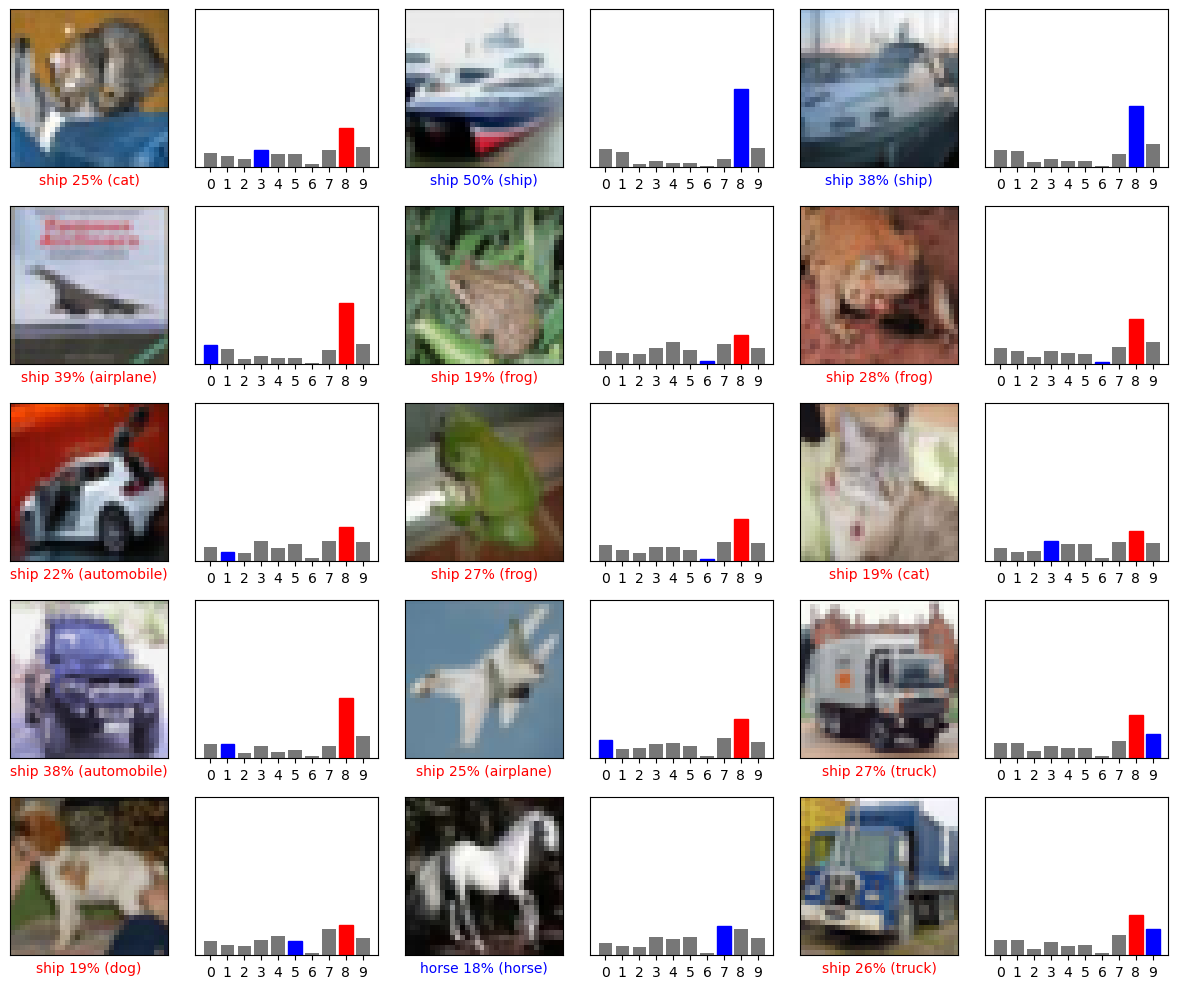

In [50]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()